*MEMO :: this codes based on tvm docker *

1)install cuda docker
https://docs.nvidia.com/datacenter/cloud-native/container-toolkit/install-guide.html#docker


```
(install nvidia driver first, )
$>distribution=$(. /etc/os-release;echo $ID$VERSION_ID)    && curl -s -L https://nvidia.github.io/nvidia-docker/gpgkey | sudo apt-key add -    && curl -s -L https://nvidia.github.io/nvidia-docker/$distribution/nvidia-docker.list | sudo tee /etc/apt/sources.list.d/nvidia-docker.list

$>curl -s -L https://nvidia.github.io/nvidia-container-runtime/experimental/$distribution/nvidia-container-runtime.list | sudo tee /etc/apt/sources.list.d/nvidia-container-runtime.list

$>sudo apt-get update
$>sudo apt-get install -y nvidia-docker2
$>sudo systemctl restart docker
$>sudo docker run --rm --gpus all nvidia/cuda:11.0-base nvidia-smi
```

2)build tvm docker
https://tvm.apache.org/docs/install/docker.html
```
$>git clone --recursive https://github.com/apache/tvm tvm
$>cd tvm
$>sudo ./docker/build.sh ci_gpu make -j$(nproc)
$>sudo ./docker/bash.sh ci_gpu
```

Import Library

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

CNN Network

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


Training

In [3]:
def train(model, device, train_loader, optimizer, epoch , log_interval , dry_run):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if dry_run:
                break

Fast Forward

In [4]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

Hyper Parameter

In [5]:
training_eneble = True
batch_size      = 64
test_batch_size = 1000
epochs          = 10
lr              = 0.8
lr_gamma        = 0.7
dry_run         = False
seed            = 1
log_interval    = 10

exec

In [6]:
if training_eneble:
    use_cuda = torch.cuda.is_available()
    print("gpu_enable::",use_cuda)

    torch.manual_seed(seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    train_kwargs = {'batch_size': batch_size}
    test_kwargs = {'batch_size': test_batch_size}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    dataset1 = datasets.MNIST('./data', train=True, download=True,transform=transform)
    dataset2 = datasets.MNIST('./data', train=False, transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=lr)

    scheduler = StepLR(optimizer, step_size=1, gamma=lr_gamma )
    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch,log_interval , dry_run)
        test(model, device, test_loader)
        scheduler.step()
    torch.save(model.state_dict(), "mnist_cnn.pt")

gpu_enable:: True
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.283075
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.854550
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.886880
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.626352
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.428285
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.451706
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.202448
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.486756
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.263736
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.165514
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.235124
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.189561
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.275750
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.217383
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.314274
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.123608
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.267033
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.135488
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.340879
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.160573
Train Epoch

Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.117704
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.012902
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.120033
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.177441
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.120855
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.092808
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.217635
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.047504
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.024763
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.038987
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.032380
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.017602
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.088567
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.298559
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.144357
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.023314
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.009437
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.127436
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.022474
Train Epoch: 2 [56960/60000 (95%)]	Loss: 0.098137


Train Epoch: 4 [28800/60000 (48%)]	Loss: 0.068549
Train Epoch: 4 [29440/60000 (49%)]	Loss: 0.008917
Train Epoch: 4 [30080/60000 (50%)]	Loss: 0.054314
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.157396
Train Epoch: 4 [31360/60000 (52%)]	Loss: 0.003120
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.040019
Train Epoch: 4 [32640/60000 (54%)]	Loss: 0.045624
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.118932
Train Epoch: 4 [33920/60000 (57%)]	Loss: 0.008686
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.013638
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.008107
Train Epoch: 4 [35840/60000 (60%)]	Loss: 0.011414
Train Epoch: 4 [36480/60000 (61%)]	Loss: 0.064353
Train Epoch: 4 [37120/60000 (62%)]	Loss: 0.001595
Train Epoch: 4 [37760/60000 (63%)]	Loss: 0.027805
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.009282
Train Epoch: 4 [39040/60000 (65%)]	Loss: 0.159181
Train Epoch: 4 [39680/60000 (66%)]	Loss: 0.002192
Train Epoch: 4 [40320/60000 (67%)]	Loss: 0.018605
Train Epoch: 4 [40960/60000 (68%)]	Loss: 0.009220


Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.091599
Train Epoch: 6 [13440/60000 (22%)]	Loss: 0.017207
Train Epoch: 6 [14080/60000 (23%)]	Loss: 0.021623
Train Epoch: 6 [14720/60000 (25%)]	Loss: 0.024912
Train Epoch: 6 [15360/60000 (26%)]	Loss: 0.085948
Train Epoch: 6 [16000/60000 (27%)]	Loss: 0.022329
Train Epoch: 6 [16640/60000 (28%)]	Loss: 0.002952
Train Epoch: 6 [17280/60000 (29%)]	Loss: 0.001528
Train Epoch: 6 [17920/60000 (30%)]	Loss: 0.035349
Train Epoch: 6 [18560/60000 (31%)]	Loss: 0.066410
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.029420
Train Epoch: 6 [19840/60000 (33%)]	Loss: 0.004631
Train Epoch: 6 [20480/60000 (34%)]	Loss: 0.179792
Train Epoch: 6 [21120/60000 (35%)]	Loss: 0.002864
Train Epoch: 6 [21760/60000 (36%)]	Loss: 0.026248
Train Epoch: 6 [22400/60000 (37%)]	Loss: 0.006580
Train Epoch: 6 [23040/60000 (38%)]	Loss: 0.046260
Train Epoch: 6 [23680/60000 (39%)]	Loss: 0.005072
Train Epoch: 6 [24320/60000 (41%)]	Loss: 0.003207
Train Epoch: 6 [24960/60000 (42%)]	Loss: 0.022289


Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.028684
Train Epoch: 7 [58240/60000 (97%)]	Loss: 0.008414
Train Epoch: 7 [58880/60000 (98%)]	Loss: 0.109146
Train Epoch: 7 [59520/60000 (99%)]	Loss: 0.064974

Test set: Average loss: 0.0276, Accuracy: 9904/10000 (99%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.125673
Train Epoch: 8 [640/60000 (1%)]	Loss: 0.004081
Train Epoch: 8 [1280/60000 (2%)]	Loss: 0.001761
Train Epoch: 8 [1920/60000 (3%)]	Loss: 0.002217
Train Epoch: 8 [2560/60000 (4%)]	Loss: 0.005315
Train Epoch: 8 [3200/60000 (5%)]	Loss: 0.000741
Train Epoch: 8 [3840/60000 (6%)]	Loss: 0.002884
Train Epoch: 8 [4480/60000 (7%)]	Loss: 0.003131
Train Epoch: 8 [5120/60000 (9%)]	Loss: 0.002358
Train Epoch: 8 [5760/60000 (10%)]	Loss: 0.002918
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.007068
Train Epoch: 8 [7040/60000 (12%)]	Loss: 0.025591
Train Epoch: 8 [7680/60000 (13%)]	Loss: 0.002043
Train Epoch: 8 [8320/60000 (14%)]	Loss: 0.004044
Train Epoch: 8 [8960/60000 (15%)]	Loss: 0.006418
Train Epoch: 8 [9

Train Epoch: 9 [41600/60000 (69%)]	Loss: 0.017917
Train Epoch: 9 [42240/60000 (70%)]	Loss: 0.050050
Train Epoch: 9 [42880/60000 (71%)]	Loss: 0.043295
Train Epoch: 9 [43520/60000 (72%)]	Loss: 0.004214
Train Epoch: 9 [44160/60000 (74%)]	Loss: 0.010186
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.002984
Train Epoch: 9 [45440/60000 (76%)]	Loss: 0.157057
Train Epoch: 9 [46080/60000 (77%)]	Loss: 0.053225
Train Epoch: 9 [46720/60000 (78%)]	Loss: 0.000792
Train Epoch: 9 [47360/60000 (79%)]	Loss: 0.006040
Train Epoch: 9 [48000/60000 (80%)]	Loss: 0.004687
Train Epoch: 9 [48640/60000 (81%)]	Loss: 0.023549
Train Epoch: 9 [49280/60000 (82%)]	Loss: 0.003583
Train Epoch: 9 [49920/60000 (83%)]	Loss: 0.210050
Train Epoch: 9 [50560/60000 (84%)]	Loss: 0.095180
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.002447
Train Epoch: 9 [51840/60000 (86%)]	Loss: 0.000981
Train Epoch: 9 [52480/60000 (87%)]	Loss: 0.002573
Train Epoch: 9 [53120/60000 (88%)]	Loss: 0.044347
Train Epoch: 9 [53760/60000 (90%)]	Loss: 0.002936


Save as ONNX

In [7]:
import torch.onnx
# Providing input and output names sets the display names for values
# within the model's graph. Setting these does not change the semantics
# of the graph; it is only for readability.
#
# The inputs to the network consist of the flat list of inputs (i.e.
# the values you would pass to the forward() method) followed by the
# flat list of parameters. You can partially specify names, i.e. provide
# a list here shorter than the number of inputs to the model, and we will
# only set that subset of names, starting from the beginning.
dummy_input = torch.randn(10, 1, 28, 28, device="cuda")
input_names = [ "actual_input_1" ] + [ "learned_%d" % i for i in range(8) ]
output_names = [ "output1" ]

torch.onnx.export(model, dummy_input, "example_onnx_tvm_mnist.onnx", verbose=True, input_names=input_names, output_names=output_names)

graph(%actual_input_1 : Float(10, 1, 28, 28, strides=[784, 784, 28, 1], requires_grad=0, device=cuda:0),
      %learned_0 : Float(32, 1, 3, 3, strides=[9, 9, 3, 1], requires_grad=1, device=cuda:0),
      %learned_1 : Float(32, strides=[1], requires_grad=1, device=cuda:0),
      %learned_2 : Float(64, 32, 3, 3, strides=[288, 9, 3, 1], requires_grad=1, device=cuda:0),
      %learned_3 : Float(64, strides=[1], requires_grad=1, device=cuda:0),
      %learned_4 : Float(128, 9216, strides=[9216, 1], requires_grad=1, device=cuda:0),
      %learned_5 : Float(128, strides=[1], requires_grad=1, device=cuda:0),
      %learned_6 : Float(10, 128, strides=[128, 1], requires_grad=1, device=cuda:0),
      %learned_7 : Float(10, strides=[1], requires_grad=1, device=cuda:0)):
  %9 : Float(10, 32, 26, 26, strides=[21632, 676, 26, 1], requires_grad=1, device=cuda:0) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[0, 0, 0, 0], strides=[1, 1]](%actual_input_1, %learned_0, %learned_1) # /u

Check loaded-NN is actually working

target= 7
infer_res= tensor([7])


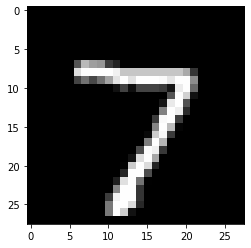

In [8]:
##ONNX load is not supported in pytorch
#re-load model from .pt for TVM check
model_infer = Net()
model_infer.load_state_dict(torch.load("mnist_cnn.pt"))

##check loaded model is working
import matplotlib.pyplot as plt
sample0, ref = dataset2[0]
plt.imshow(sample0.numpy()[0], cmap='gray')
print("target=",ref)
sample0 = sample0.view(1,1,28,28) #add barch1 dimension
infer_res = model_infer(sample0)
print("infer_res=",infer_res.argmax(dim=1, keepdim=False))

check_all_eneble = False
if check_all_eneble:
    test_batch1_kwargs = {'batch_size': 1}
    test_batch1_loader = torch.utils.data.DataLoader(dataset2, **test_batch1_kwargs)
    for data, target in test_batch1_loader:
        output = model_infer(data)
        pred = output.argmax(dim=1, keepdim=False)
        print("infer" , pred)
        print("ref" , target)

ONNX Load NNs

In [9]:
import onnx
# Load the ONNX model
model_onnx = onnx.load("example_onnx_tvm_mnist.onnx")

# Check that the model is well formed
onnx.checker.check_model(model_onnx)

# Print a human readable representation of the graph
print(onnx.helper.printable_graph(model_onnx.graph))

graph torch-jit-export (
  %actual_input_1[FLOAT, 10x1x28x28]
) initializers (
  %learned_0[FLOAT, 32x1x3x3]
  %learned_1[FLOAT, 32]
  %learned_2[FLOAT, 64x32x3x3]
  %learned_3[FLOAT, 64]
  %learned_4[FLOAT, 128x9216]
  %learned_5[FLOAT, 128]
  %learned_6[FLOAT, 10x128]
  %learned_7[FLOAT, 10]
) {
  %9 = Conv[dilations = [1, 1], group = 1, kernel_shape = [3, 3], pads = [0, 0, 0, 0], strides = [1, 1]](%actual_input_1, %learned_0, %learned_1)
  %10 = Relu(%9)
  %11 = Conv[dilations = [1, 1], group = 1, kernel_shape = [3, 3], pads = [0, 0, 0, 0], strides = [1, 1]](%10, %learned_2, %learned_3)
  %12 = Relu(%11)
  %13 = MaxPool[kernel_shape = [2, 2], pads = [0, 0, 0, 0], strides = [2, 2]](%12)
  %14 = Flatten[axis = 1](%13)
  %15 = Gemm[alpha = 1, beta = 1, transB = 1](%14, %learned_4, %learned_5)
  %16 = Relu(%15)
  %17 = Gemm[alpha = 1, beta = 1, transB = 1](%16, %learned_6, %learned_7)
  %output1 = LogSoftmax[axis = 1](%17)
  return %output1
}


TVM compile test

In [12]:
import tvm
from tvm import relay

#from tvm.driver import tvmc
#model_tvm_onnx = tvmc.load("example_onnx_tvm_mnist.onnx") #Step 1: Load
#package = tvmc.compile(model_tvm_onnx, target="llvm") #Step 2: Compile

target = "llvm"

input_name = "actual_input_1"
shape_dict = {input_name: sample0.shape}
mod, params = relay.frontend.from_onnx(model_onnx, shape_dict)

with tvm.transform.PassContext(opt_level=1):
    executor = relay.build_module.create_executor(
        "graph", mod, tvm.cpu(0), target, params
    ).evaluate()

#target = 'cuda'
#target_host = 'llvm'
#ctx = tvm.context(target, 0)

#shape = (1, 1, 28, 28)
#model_relay, params = tvm.relay.frontend.from_onnx(model_onnx,{"actual_input_1": shape})

#build
#with relay.build_config(opt_level=3):
#    graph, lib, params = relay.build(model_relay,
#                                     target=target,
#                                     target_host=target_host,
#                                     params=params)
#m = graph_runtime.create(graph, lib, ctx)



NameError: name 'onnx_model' is not defined